In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')

import csv
import numpy as np
import pandas as pd
import scipy.io
from spykes.neurovis import NeuroVis
from spykes.popvis import PopVis

# Neuropixels

Neuropixels is a new recording technique by [UCL's Cortex Lab](https://www.ucl.ac.uk/cortexlab/neuropixels) that is able to measure data from from hundreds of neurons. Below we show how this data can be worked with in Spykes.

### 0. Download Data

Download all data [here](http://data.cortexlab.net/dualPhase3/data/). 

We use the files:
    
    timeCorrection.npy
    experiment1stimInfo.mat
    frontal/
        spike_clusters.npy
        spike_times.npy
        cluster_groups.csv
        spike_templates.npy
        templates.npy
        whitening_mat_inv.npy
        channel_positions.npy
    posterior/
        spike_clusters.npy
        spike_times.npy
        cluster_groups.csv
        spike_templates.npy
        templates.npy
        whitening_mat_inv.npy
        channel_positions.npy

### 1. Read In Data

In [2]:
folderNames = ['posterior', 'frontal']
Fs = 30000.0

striatum = list()
motorCtx = list()
thalamus = list()
hippocampus = list()
visualCtx = list()

# a lot of this code is adapted from Cortex Lab's MATLAB script
# see here: http://data.cortexlab.net/dualPhase3/data/script_dualPhase3.m

for name in folderNames:
    
    clusters = np.squeeze(np.load(name + '/spike_clusters.npy'))
    spikeTimes = (np.squeeze(np.load(name + '/spike_times.npy')))/Fs
    spikeTemplates = (np.squeeze(np.load(name + '/spike_templates.npy')))
    
    temps = (np.squeeze(np.load(name + '/templates.npy')))
    winv = (np.squeeze(np.load(name + '/whitening_mat_inv.npy')))
    yCoords = (np.squeeze(np.load(name + '/channel_positions.npy')))[:,1]
    
    # frontal times need to align with posterior
    if (name == 'frontal'):
        timeCorrection = np.load('timeCorrection.npy')
        spikeTimes *= timeCorrection[0] 
        spikeTimes += timeCorrection[1]
    
    data = np.recfromcsv(name + '/cluster_groups.csv', delimiter = '\t')
    cids = np.array([x[0] for x in data])
    cfg = np.array([x[1] for x in data])
    
    
    # find good clusters and only use those spikes
    goodClusters = cids[cfg == 'good']
    goodIndices = (np.in1d(clusters, goodClusters))
        
    realSpikes = spikeTimes[goodIndices]
    realClusters = clusters[goodIndices]
    realSpikeTemplates = spikeTemplates[goodIndices]
    
    # find how many spikes per cluster and then order spikes by which cluster they are in
    
    countsPerCluster = np.bincount(realClusters)
    
    sort_idx = np.argsort(realClusters) 
    sortedClusters = realClusters[sort_idx]
    sortedSpikes = realSpikes[sort_idx]
    sortedSpikeTemplates = realSpikeTemplates[sort_idx]
    
    # find depth for each spike
    # this is translated from Cortex Lab's MATLAB code
    # for more details, check out the original code here: 
    # https://github.com/cortex-lab/spikes/blob/master/analysis/templatePositionsAmplitudes.m
    
    tempsUnW = np.zeros(temps.shape)
    for t in range(temps.shape[0]):
        tempsUnW[t,:,:] = np.dot(temps[t,:,:],winv)
        
    
    tempChanAmps = np.max(tempsUnW, axis=1) - np.min(tempsUnW, axis=1)
    tempsAmps = np.max(tempChanAmps, axis=1)
    threshVals = tempsAmps * 0.3
    
    threshVals = [threshVals for i in range(tempChanAmps.shape[1])]
    threshVals = np.stack(threshVals, axis=1)
    
    tempChanAmps[tempChanAmps < threshVals] = 0
        
    yCoords = np.reshape(yCoords, (yCoords.shape[0], 1))
    tempDepths = np.sum(np.dot(tempChanAmps,yCoords), axis=1) / (np.sum(tempChanAmps,axis=1))
    
    sortedSpikeDepths = tempDepths[sortedSpikeTemplates]
    
    # create neurons and find region
                
    accumulator = 0
    
    for i, count in enumerate(countsPerCluster):
        
        if count > 0:
            
            spiketimes = sortedSpikes[accumulator:accumulator+count]
            neuron = NeuroVis(spiketimes=spiketimes, name='%d' % (i))
            clusterDepth = np.mean(sortedSpikeDepths[accumulator:accumulator+count])
            
            if name == 'frontal':
                
                if (clusterDepth > 0 and clusterDepth < 1550):
                    striatum.append(neuron)
                elif (clusterDepth > 1550 and clusterDepth < 3840):
                    motorCtx.append(neuron)
            
            elif name == 'posterior':
                
                if (clusterDepth > 0 and clusterDepth < 1634):
                    thalamus.append(neuron)
                elif (clusterDepth > 1634 and clusterDepth < 2797):
                    hippocampus.append(neuron)
                elif (clusterDepth > 2797 and clusterDepth < 3840):
                    visualCtx.append(neuron)
                
            accumulator += count
    

print "Striatum (n = %d)" % len(striatum)
print "Motor Cortex (n = %d)" % len(motorCtx)
print "Thalamus (n = %d)" % len(thalamus)
print "Hippocampus (n = %d)" % len(hippocampus)
print "Visual Cortex (n = %d)" % len(visualCtx)

    

Striatum (n = 200)
Motor Cortex (n = 243)
Thalamus (n = 244)
Hippocampus (n = 68)
Visual Cortex (n = 76)


### 2. Create Data Frame

In [3]:
df = pd.DataFrame()

rawData = scipy.io.loadmat('experiment1stimInfo.mat')

df['start'] = np.squeeze(rawData['stimStarts'])
df['stop'] = np.squeeze(rawData['stimStops'])
df['stimulus'] = np.squeeze(rawData['stimIDs'])

print df.head()

        start        stop  stimulus
0   99.108333  101.108333         6
1  101.908333  103.908333         3
2  104.924667  106.924667        11
3  107.574667  109.574667         7
4  110.308000  112.308000         8


### 3. Start Plotting

#### 3.1 Striatum

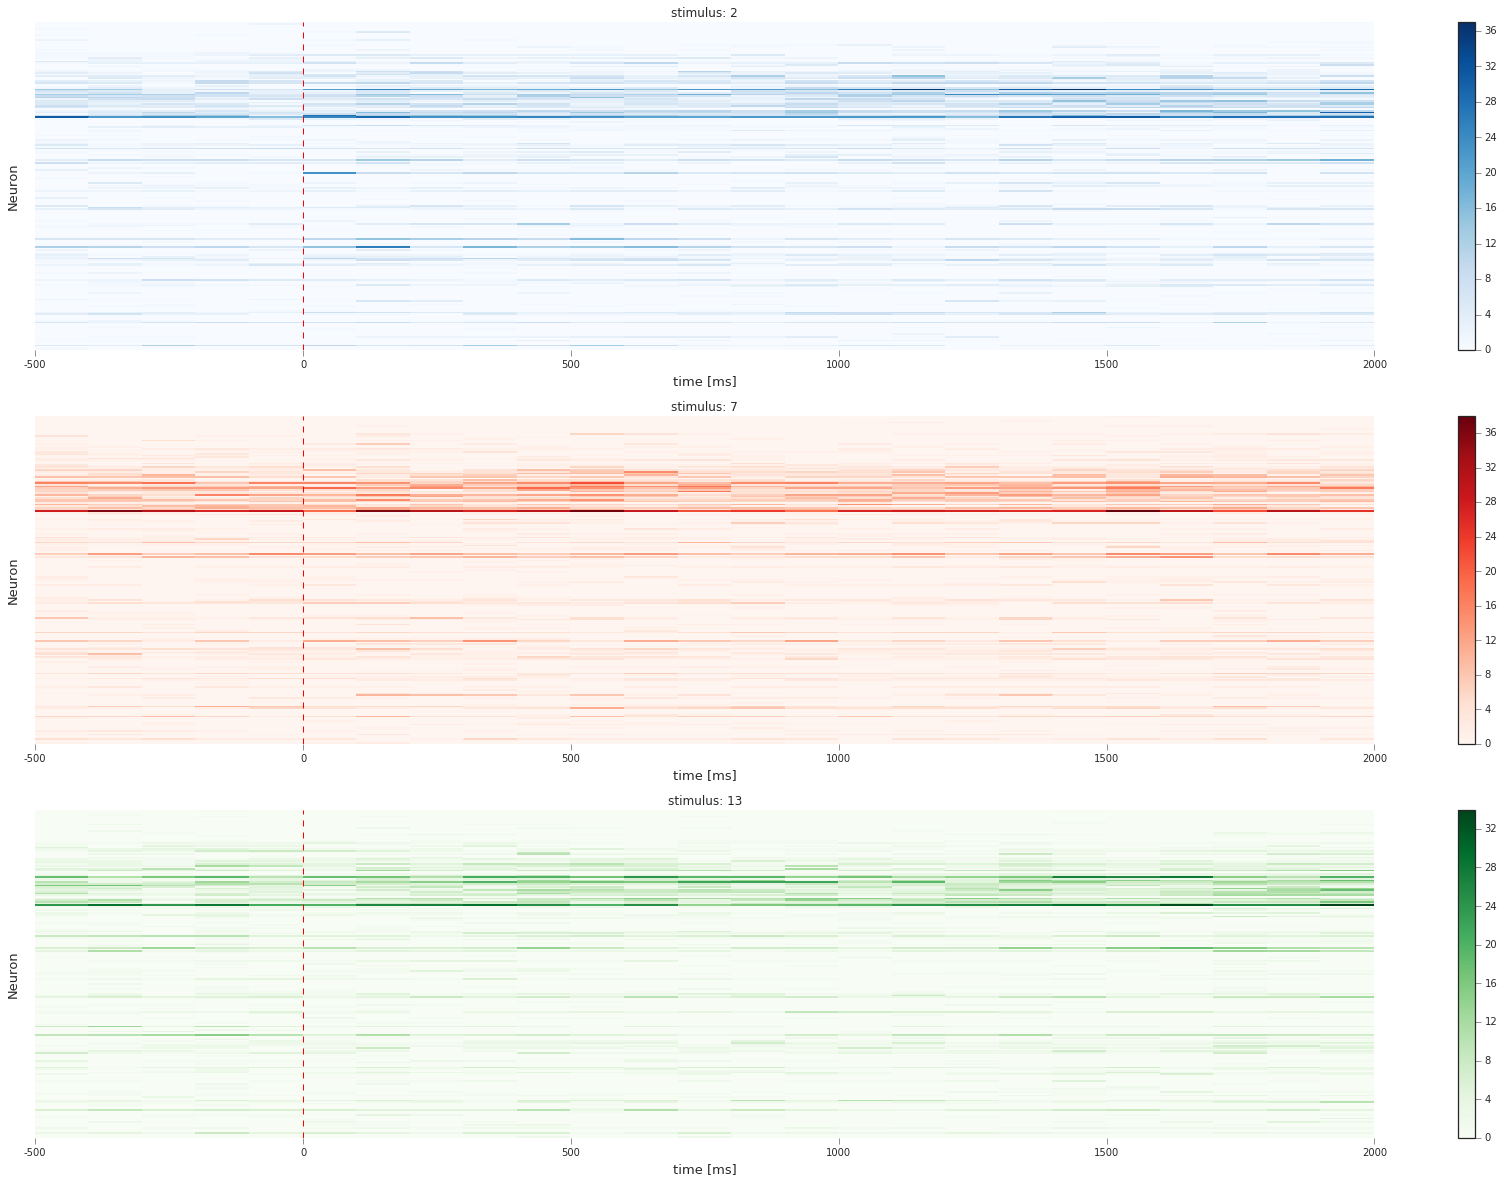

In [4]:
pop = PopVis(striatum, name='Striatum') 

fig = plt.figure(figsize=(30,20))

all_psth = pop.get_all_psth(event='start', df=df, conditions='stimulus', plot=False, binsize=100, window = [-500, 2000])

pop.plot_heat_map(all_psth, cond_id=[2, 7, 13], sortorder='descend', neuron_names=False) # cond_id chosen randomly

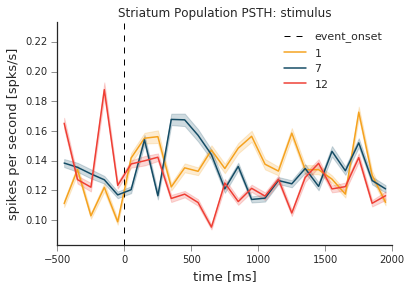

In [5]:
pop.plot_population_psth(all_psth=all_psth, cond_id=[1, 7, 12])

#### 3.2 Frontal

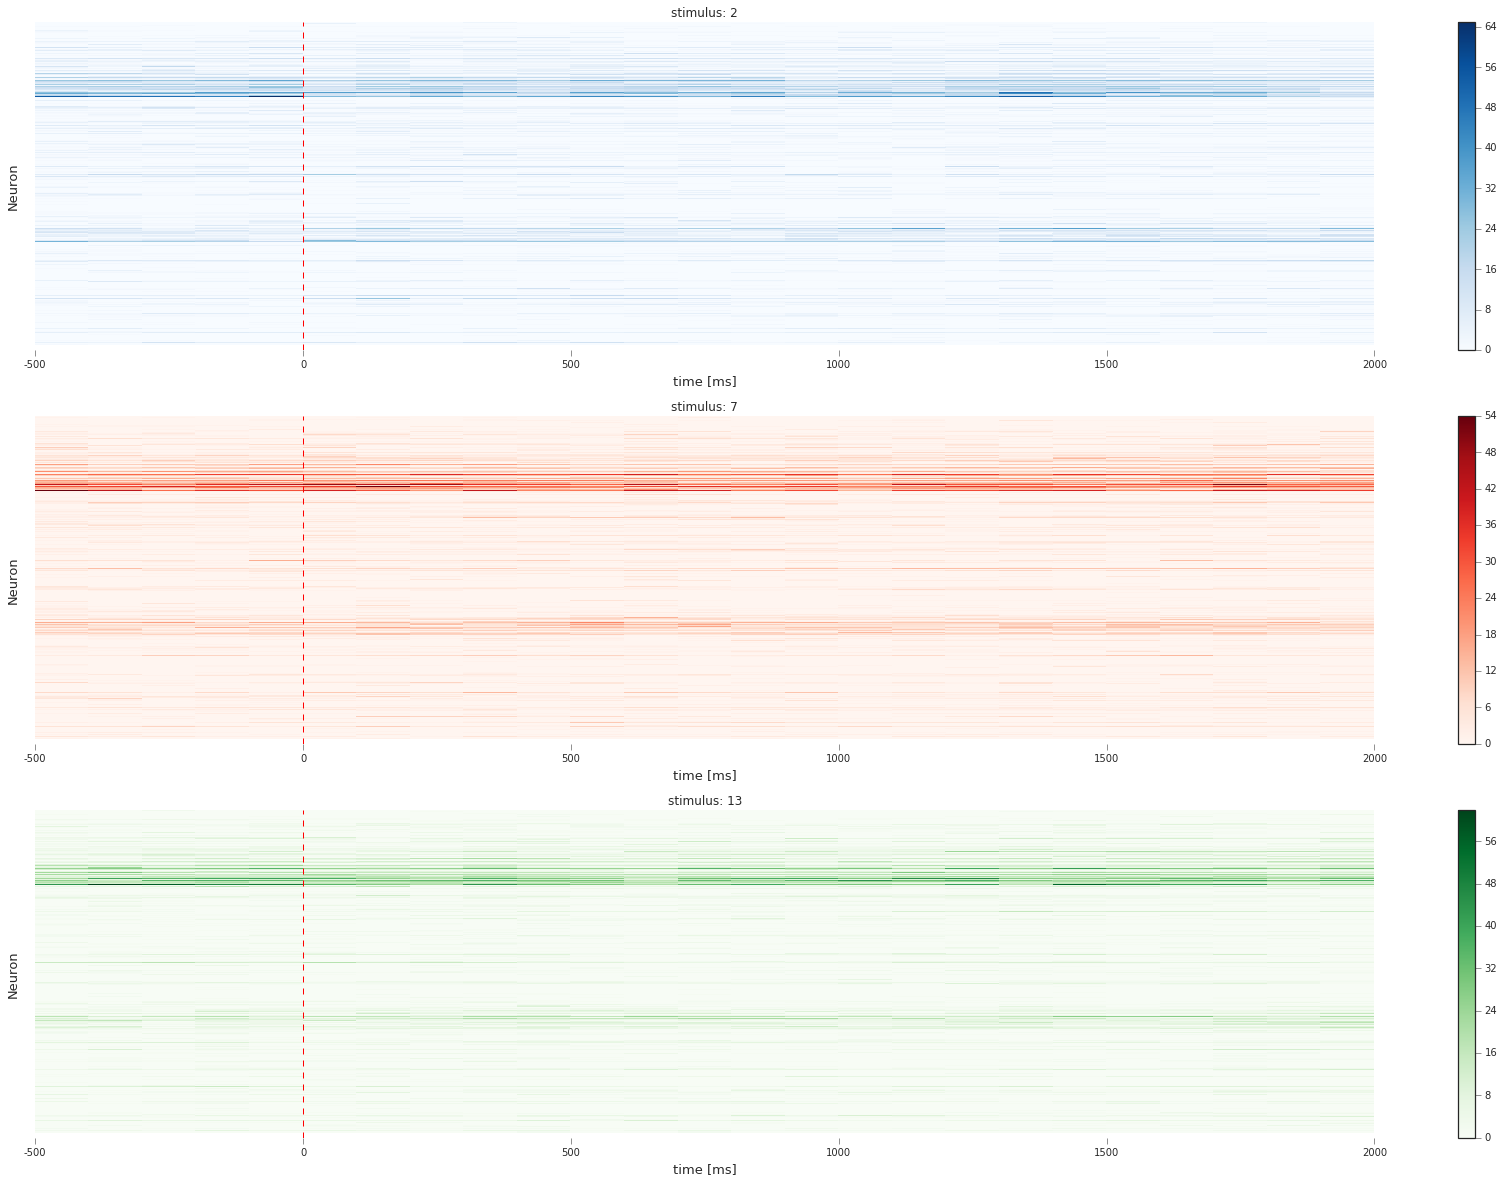

In [6]:
pop = PopVis(striatum + motorCtx, name='Frontal') 

fig = plt.figure(figsize=(30,20))

all_psth = pop.get_all_psth(event='start', df=df, conditions='stimulus', plot=False, binsize=100, window = [-500, 2000])

pop.plot_heat_map(all_psth, cond_id=[2, 7, 13], sortorder='descend', neuron_names=False)

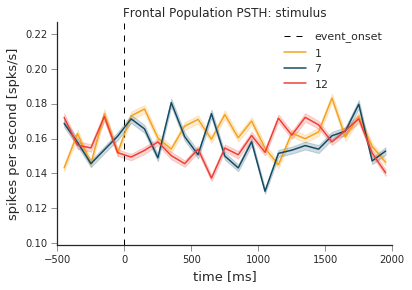

In [ ]:
pop.plot_population_psth(all_psth=all_psth, cond_id=[1, 7, 12])

#### 3.3 All Neurons

In [ ]:
pop = PopVis(striatum + motorCtx + thalamus + hippocampus + visualCtx) 

fig = plt.figure(figsize=(30,20))

all_psth = pop.get_all_psth(event='start', df=df, conditions='stimulus', plot=False, binsize=100, window = [-500, 2000])

pop.plot_heat_map(all_psth, cond_id=[2, 7, 13], sortorder='descend', neuron_names=False)

In [ ]:
pop.plot_population_psth(all_psth=all_psth, cond_id=[1, 7, 12])

#### 3.4 Striatum vs. Motor Cortex

In [ ]:
striatumPop = PopVis(striatum, name='Striatum') 
motorCtxPop = PopVis(motorCtx, name='Motor Cortex') 

striatum_psth = striatumPop.get_all_psth(event='start', df=df, conditions='stimulus', plot=False, binsize=100, window = [-500, 2000])
motorCtx_psth = motorCtxPop.get_all_psth(event='start', df=df, conditions='stimulus', plot=False, binsize=100, window = [-500, 2000])

In [ ]:
striatumPop.plot_population_psth(all_psth=striatum_psth, cond_id=[1, 7, 12])

In [ ]:
motorCtxPop.plot_population_psth(all_psth=motorCtx_psth, cond_id=[1, 7, 12])